In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'

# Kalibratie van een tijdreeksmodel

**Inhoudsopgave**

- [Introductie](#Introductie)
- [Effect van de lengte van de tijdreeks (of kalibratieperiode)](#Effect-van-de-lengte-van-de-tijdreeks-(of-kalibratieperiode))
- [Het ruismodel](#Het-ruismodel)
- [Effect van een ruismodel](#Effect-van-een-ruismodel)
- [Effect van het ruismodel op de schatting van de waarden en betrouwbaarheid van de parameters](#Effect-van-het-ruismodel-op-de-schatting-van-de-waarden-en-betrouwbaarheid-van-de-parameters)
- [Effect van een fout in de gemeten grondwateraanvulling](#Effect-van-een-fout-in-de-gemeten-grondwateraanvulling)
- [Effect van de meetfrequentie op de werking van het AR1 ruismodel](#Effect-van-de-meetfrequentie-op-de-werking-van-het-AR1-ruismodel)

## Introductie

Onder kalibratie van een tijdreeksmodel verstaan we het vinden van de modelparameters zodat de (met het tijdreeksmodel) gesimuleerde stijghoogtes zo goed mogelijk overeenkomen met de gemeten stijghoogtes. De gevonden parameters worden de optimale parameters genoemd. De meest gebruikte methode om de optimale parameters te vinden is de minimalisatie van de de som van de kwadraten van de verschillen tussen de gemeten stijghoogtes en de gemodelleerde stijghoogtes, ook wel de kleinste kwadraten methode genoemd. De som van de kwadraten is een niet-lineaire functie van de modelparameters. Om de optimale modelparameters te vinden wordt gebruikt gemaakt van een zoekmethode. 

Er bestaan een aantal verschillende zoekmethoden die gebruikt kunnen worden om de optimale modelparameters te vinden. Iedere zoekmethode is gebaseerd op een ander zoek algoritme, maar het idee is altijd hetzelfde: het model wordt een aantal keer gedraaid met verschillende waarden van de modelparameters. Gebaseerd op de verschillende modeluitkomsten (en de daaruit voorvloeiende som van de kwadraten) bepaald het zoekalgoritme een volgende mogelijke set modelparameters die een kleinere som van de kwadraten zou kunnen opleveren. Het zoekalgoritme gaat door totdat het besluit dat de beste parameters gevonden zijn. De efficiëntie van het zoekalgoritme wordt bepaald door het aantal keer dat het model gedraaid moet worden om de optimale modelparameters te vinden. Het is vanzelfsprekend aan te bevelen om de initiēle modelparameters zo dicht mogelijk bij de optimale modelparameters te kiezen. Daartoe heeft de meeste software geprobeerd om slimme keuzes te maken voor de initiēle waarden van de modelparameters en de initiële parameters deels afhankelijk te maken van de waarden van de invoerreeksen. Soms heeft de modelleur specifieke kennis van het systeem waardoor betere initiēle waarden gekozen kunnen worden. 

De meest gebruikte zoekalgoritmes zoeken de optimale modelparameters door de modelparameters steeds een beetje aan te passen zodat de som van de kwadraten steeds een beetje kleiner wordt. Op deze manier leidt er een direct pad van de initiēle waarden naar de optimale waarden en bij elk stapje langs het pad is de som van de kwadraten kleiner. Dit kan tot gevolg hebben dat het zoekalgoritme in een lokaal minimum belandt. Het is namelijk goed mogelijk dat langs het pad van de initiēle parameter waarden naar de optimale parameter waarden de kwadraten som een tijdje toeneemt voordat het weer afneemt. Er bestaan geavanceerde zoekalgoritmes die het model ook draaien met modelparameters die juist een grotere kwadraten som geven met als doel om uiteindelijk het globale minimum te vinden. Dit kost vanzelfsprekend (veel) meer rekentijd. 

Ter illustratie wordt hieronder het verloop van de zes parameters en de doelfunctie (in dit geval de 'root mean squared noise') weergegeven voor elke run tijdens het zoekproces naar de optimale parameters. Dezelfde buis wordt in het volgende voorbeeld gebruikt, waar de buis verder beschreven wordt. Voor elke iteratie in het zoekproces wordt het model een aantal keer gedraaid, tenminste 1 keer per parameter. Vandaar dat parameters stapgewijs omhoog of omlaag gaan. Het model is bijna 100 keer gedraaid om de optimale parameters te vinden. 

In [2]:
ho = ps.read.read_dino('data/B58C0698001_1.csv').series.loc['1990':'2009']
rain = ps.read.read_knmi('data/neerslaggeg_HEIBLOEM-L_967.txt',
                         variables='RD').series.loc['1980':'2009']
evap = ps.read.read_knmi('data/etmgeg_380.txt',
                         variables='EV24').series.loc['1980':'2009']

In [3]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
track = ps.TrackSolve(ml)
ml.solve(report=False, callback=track.track_solve)

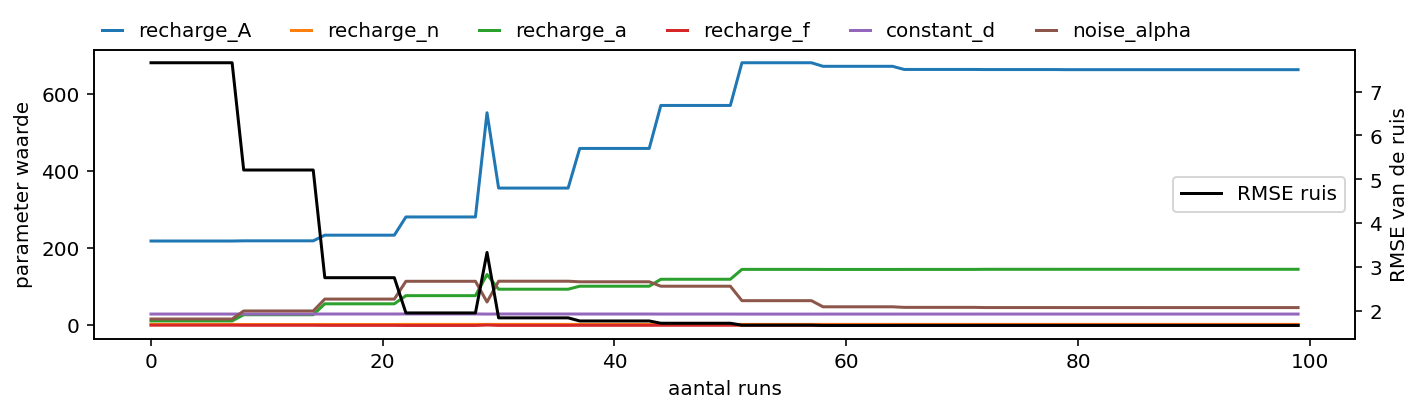

In [4]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
track.parameters.plot(ax=ax)
plt.xlabel('aantal runs')
plt.ylabel('parameter waarde')
ax2 = ax.twinx()
ax2.plot(track.rmse_noise, color='k', ls='-', label='RMSE ruis')
plt.ylabel('RMSE van de ruis')
ax.legend(loc=(0, 1), frameon=False,
          ncol=6, handlelength=1)
ax2.legend(loc='right')
plt.tight_layout()

## Effect van de lengte van de tijdreeks (of kalibratieperiode)

Het effect van de lengte van de kalibratieperiode op de uitkomsten van een tijdreeksmodel wordt besproken 
aan de hand van de metingen in buis B58C0698 in de plaats Swartbroek nabij Weert; de data voor de periode 1990-2010 worden beschouwd, waarin ongeveer twee keer per maand gemeten is. De regenreeks komt van regenstation Heibloem en de potentiele verdamping van weerstation Maastricht.

Er is een tijdreeksmodel gemaakt waarbij de regen en potentiële verdamping de verklarende reeksen zijn en de geschaalde Gamma functie gebruikt wordt als responsfunctie. De hele reeks wordt gebruikt om het model te kalibreren. Het model fit de data goed, zoals in onderstaande figuur te zien is. De blokrespons en staprespons functies worden ook getoond. Het geheugen van de blokrespons functie is iets meer dan 2.5 jaar. Na een regenbui op de eerste dag gaat de stijghoogte vrij snel omhoog, maar het duurt ongeveer 2.5 jaar voordat de stijghoogte weer terug is op het niveau voor de regenbui. De piek van de blokrespons functie is iets boven de 4, hetgeen betekent dat als het in een dag 1 mm regent, dat dan de stijghoogte uiteindelijk 4 mm omhoog gaat. Dat komt overeen met een effectieve porositeit (freatische berging) van 1 / 4 = 0.25, wat een redelijke waarde is. De staprespons gaat uiteindelijk naar een waarde iets boven de 650. Dat betekent dat als het vanaf de eerste dag continu 1 mm/d regent, dat dan de stijghoogte uiteindelijk iets meer dan 650 mm omhoog gaat. Dit is gelijk aan de parameter $A$ van de Gamma respons functie (zie [Notebook over modelstructuur](%%)). 

In [5]:
ho = ps.read.read_dino('data/B58C0698001_1.csv').series.loc['1990':'2009']
rain = ps.read.read_knmi('data/neerslaggeg_HEIBLOEM-L_967.txt',
                         variables='RD').series.loc['1980':'2009']
evap = ps.read.read_knmi('data/etmgeg_380.txt',
                         variables='EV24').series.loc['1980':'2009']

In [6]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False)

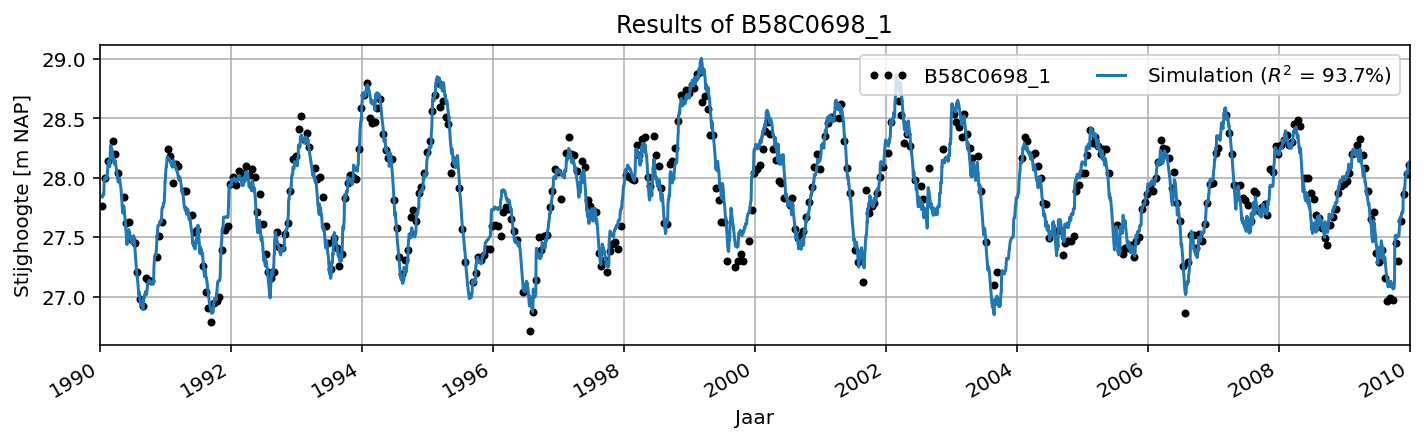

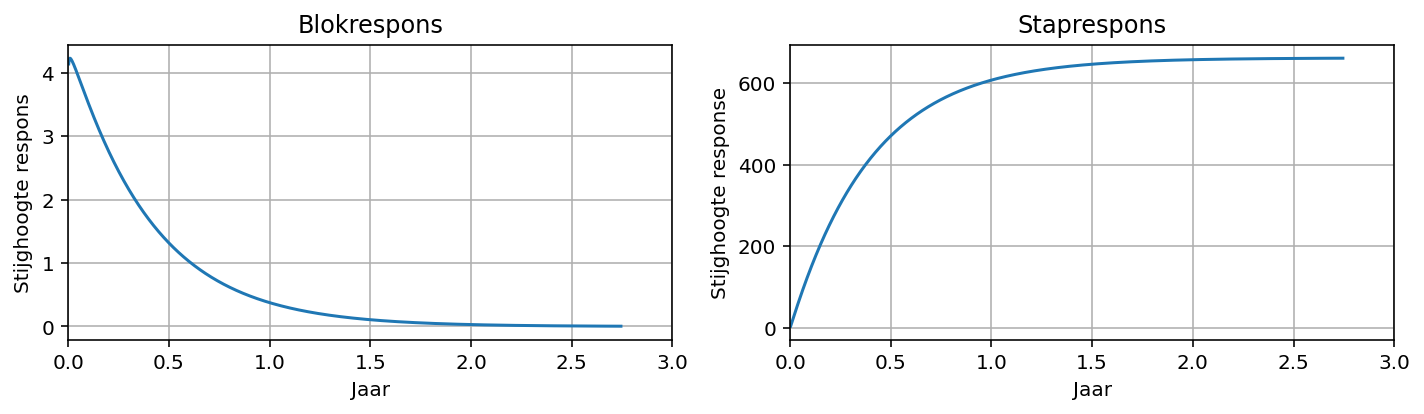

In [7]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False)

#
ml.plot(figsize=(10, 3))
plt.xlabel('Jaar')
plt.ylabel("Stijghoogte [m NAP]")
plt.grid()
plt.xlim('1990', '2010')

#
block = ml.get_block_response('recharge')
step = ml.get_step_response('recharge')
step.index /= 365
block.index /= 365
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
block.plot(ax=ax[0], ylabel='Stijghoogte respons',
           title='Blokrespons', xlabel='Jaar', xlim=(0, 3))
ax[0].grid()
step.plot(ax=ax[1], ylabel='Stijghoogte response',
          title='Staprespons', xlabel='Jaar', xlim=(0, 3))
ax[1].grid()
plt.tight_layout()

In het model hierboven wordt 20 jaar gebruikt om het model te kalibreren. Wat nu als er een kortere reeks gebruikt wordt? Wordt dan dezelfde responsfunctie gevonden? Om dit te onderzoeken wordt het model gekalibreerd op 1 jaar data (1990-1991), twee jaar data (1990-1992), etc. tot 20 jaar data (1990-2010). Voor elke kalibratie wordt de waarde van de parameter $A$ opgeslagen (de uiteindelijke hoogte van de staprepons). In onderstaande figuur wordt de gekalibreerde waarde van $A$, inclusief 95% betrouwbaarbeidsinterval, geplot tegen de lengte van de kalibratieperiode. Uit de figuur blijkt dat als de kalibratieperiode lang genoeg is, er steeds ongeveer hetzelfde uitkomt. Voor dit geval is een kalibratieperiode van 5 jaar (1990-1995) genoeg. Dat is, voor dit geval, ongeveer twee keer het geheugen van de blokrespons.  

In [8]:
Alist = []
years = np.arange(1991, 2011, 1)
for endyear in years:
    ml = ps.Model(ho.loc['1990':])
    rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
    ml.add_stressmodel(rm)
    ml.solve(tmin='1990', tmax=str(endyear), report=False)
    Alist.append(ml.parameters.loc['recharge_A', ['optimal', 'stderr']])
Alist = np.array(Alist)

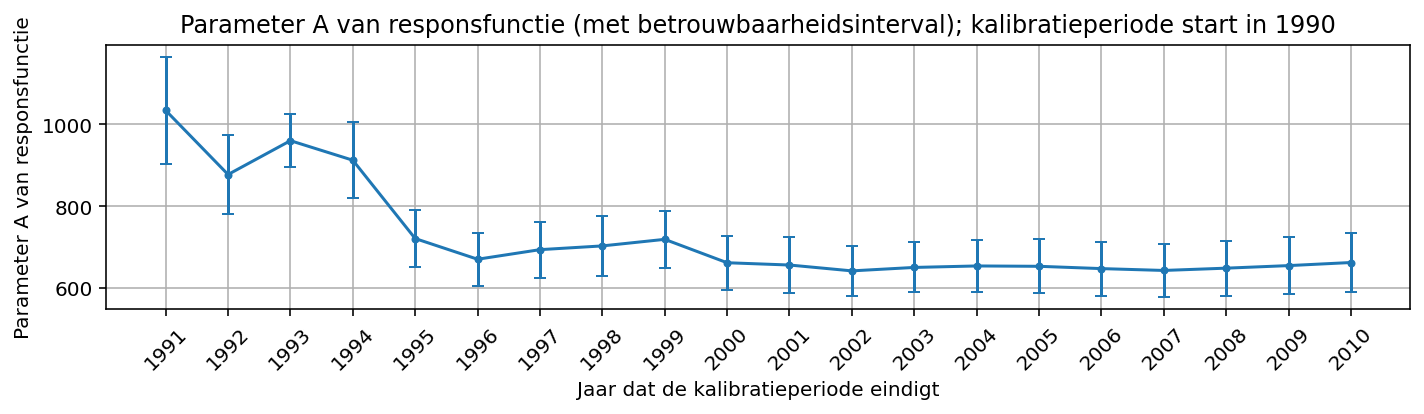

In [9]:
plt.figure(figsize=(10, 3))
plt.errorbar(years, Alist[:, 0], marker='.', yerr=2 * Alist[:, 1], capsize=3)
plt.xticks(years, rotation=45)
plt.grid()
plt.xlabel('Jaar dat de kalibratieperiode eindigt')
plt.ylabel('Parameter A van responsfunctie')
plt.title('Parameter A van responsfunctie (met betrouwbaarheidsinterval); kalibratieperiode start in 1990')
plt.tight_layout()

Bij een kortere kalibratieperiode wordt, voor dit voorbeeld, een te hoge waarde van $A$ geschat en is ook het betrouwbaarheidsinterval te klein. Immers, de waarde van $A$ die gevonden wordt voor een langere kalibratieperiode ($A\approx 650$) ligt ver buiten het betrouwbaarheidsinterval van de waarde van $A$ die gevonden wordt bij een kalibratieperiode van 1 of een paar jaar. De waarde die gevonden wordt met, bijvoorbeeld, een kalibratieperiode van 3 jaar geeft dus wel een goede fit voor de drie jaar van de kalibratieperiode, maar daarna zal de gesimuleerde stijghoogte vooral boven de gemeten stijghoogte liggen, zoals hieronder weergegeven is. Als een andere periode van 3 jaar gekozen wordt als kalibratieperiode, dan kan het model wel redelijk klopppen, zoals hieronder is weergegeven voor de periode 1993-1996, maar dat is alleen te bepalen als er ook data beschikbaar is voor de validatieperiode. 

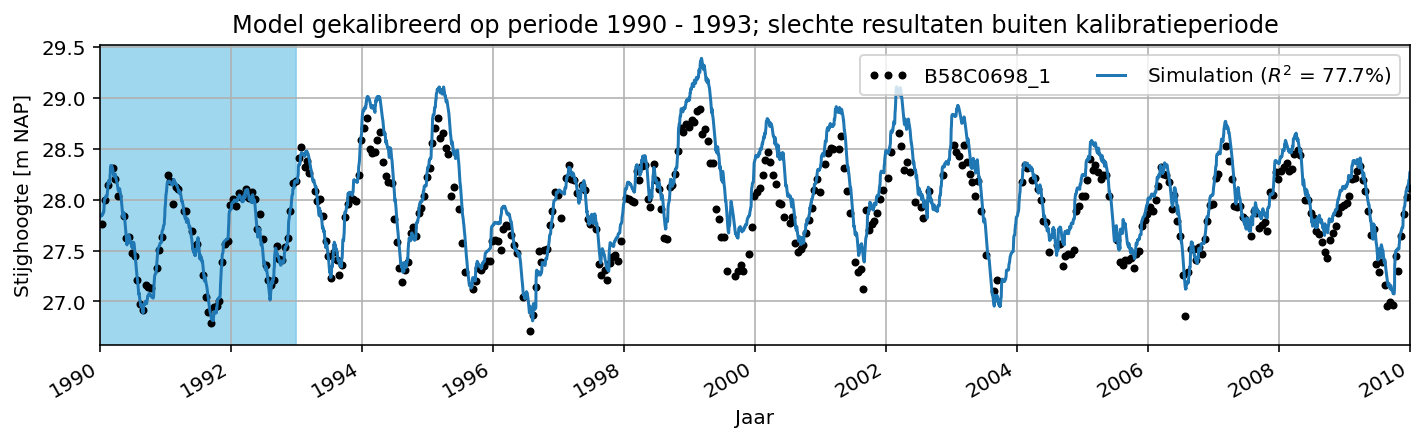

In [10]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(tmin='1990', tmax='1993', report=False)
ml.plot(tmin='1990', tmax='2010', figsize=(10, 3))
plt.xlabel('Jaar')
plt.ylabel("Stijghoogte [m NAP]")
plt.grid()
plt.title('Model gekalibreerd op periode 1990 - 1993; slechte resultaten buiten kalibratieperiode')
plt.axvspan('1990', '1993', alpha=0.8, color='skyblue');

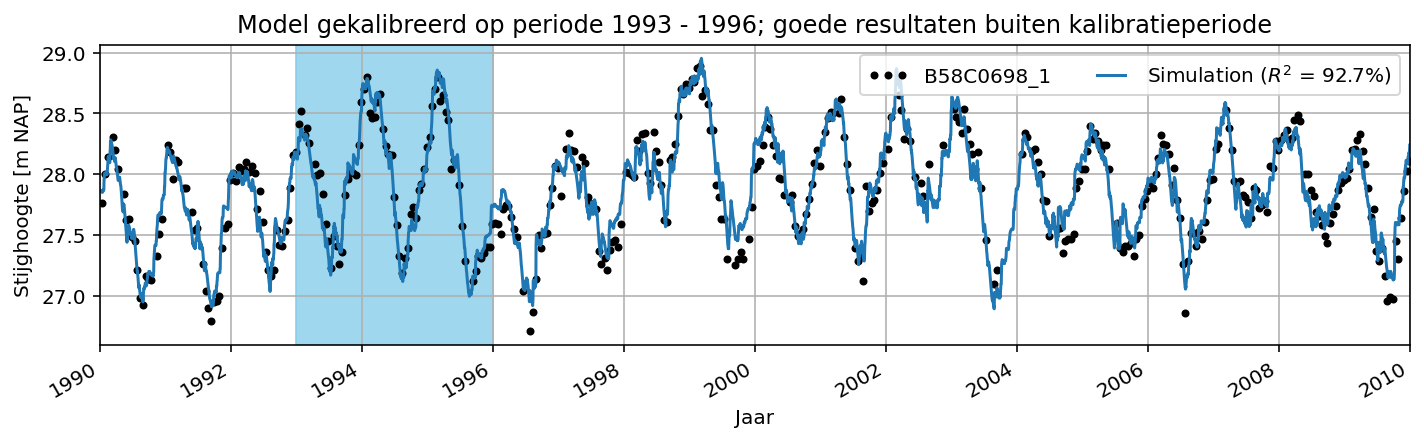

In [11]:
ml = ps.Model(ho.loc['1990':])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve(tmin='1993', tmax='1996', report=False)
ml.plot(tmin='1990', tmax='2010', figsize=(10, 3))
plt.xlabel('Jaar')
plt.ylabel("Stijghoogte [m NAP]")
plt.grid()
plt.title('Model gekalibreerd op periode 1993 - 1996; goede resultaten buiten kalibratieperiode')
plt.axvspan('1993', '1996', alpha=0.8, color='skyblue');

Intuïtief lijkt het te kloppen dat de kalibratieperiode ten minste een aantal keer het geheugen van het systeem moet zijn.
Het is echter moeilijk om een vaste regel te geven voor de benodigde lengte van de kalibratieperiode. Als voorbeeld is hierboven geïllustreerd dat 3 jaar genoeg kan zijn voor deze reeks, maar dat het wel uitmaakt welke 3 jaar gekozen worden en dat werkt natuurlijk niet prettig in de praktijk.


[Van der Spek en Bakker (2017)](#Referenties) hebben onderzocht wat de minimale lengte van een kalibratieperiode is waarna de onzekerheid van voorspelde stijghoogtes niet verder afneemt. Zij onderzochten 18 reeksen met ongeveer twee metingen per maand en responstijden die varieerden van 60 tot 1200 dagen, maar konden geen duidelijke relatie vinden tussen het geheugen van het systeem (de responstijd) en de lengte van de kalibratieperiode. Bij een kalibratieperiode van 20 jaar, vonden zij dat het gemiddelde 95% voorspellingsinterval van de stijghoogte ongeveer 50% van de totale stijghoogte variatie was (het verschil tussen de hoogst en laagst gemeten stijghoogte), terwijl het betrouwbaarheidsinterval van het model ongeveer 10% van de totale stijghoogte variatie was. Bij een kalibratieperiode van slechts 10 jaar hingen de resultaten af van welke periode van 10 jaar gekozen werd: bij sommige periodes was het betrouwbaarheidsinterval veel groter dan bij andere periodes. Bij een kalibratieperiode van slechts 5 jaar was het betrouwbaarheidsinterval vrijwel altijd groot. De conclusie van [Van der Spek en Bakker (2017)](#Referenties) is dat de betrouwbaarheid van het model toeneemt als de kalibratieperiode langer is, maar dat de betrouwbaarheid niet verder toeneemt als de de kalibratieperiode langer is dan 20 jaar. 

## Het ruismodel
Een ruismodel kan gebruikt worden om te proberen er voor te zorgen dat de overgebleven verschillen tussen het model en de metingen aan een aantal statistische toetsen voldoen zodat er statistische uitspraken gedaan kunnen worden met het model (bijvoorbeeld: wat is de kans dat de stijghoogte boven een bepaalde grenswaarde uitkomt). In het vorige model was er ook een ruismodel gebruikt, hoewel daar niet over uitgeweid is, zodat de ruis bij benadering voldeed aan de statistische toetsen en er een betrouwbaarheidsinterval van de parameters geschat kon worden. 

De verschillen tussen de gemeten stijghoogte en de gemodelleerde stijghoogte (de residuën) zijn vrijwel altijd gecorreleerd in de tijd. Simpel gezegd: als het model vandaag iets hoger is dan de gemeten stijghoogte, dan is de kans groot dat het model volgende week ook iets hoger is dan de gemeten stijghoogte. Dat is op zich prima te verklaren. Het kan bijvoorbeeld zo zijn dat er een regen reeks gebruikt wordt van een weerstation dat 20 km verderop ligt. Als het nu bij het regenstation wel geregend heeft maar bij de peilbuis niet, dan zal het model waarschijnlijk een te hoge stijghoogte simuleren. En aangezien het een tijdje duurt voordat de stijghoogte weer gezakt is na een regenbui, zal het model waarschijnlijk voor een aantal dagen/weken/maanden te hoge waarden geven. Gelukkig is de kans groot dat het een tijdje later bij de peilbuis juist wel regent terwijl het bij het regenstation niet regent, zodat de effecten elkaar weer een beetje opheffen. Een 'fout' in de regen is slechts één van de mogelijke oorzaken van een verschil tussen model en meting. Andere oorzaken zijn bijvoorbeeld meetfouten, niet gemeten veranderingen en niet-lineariteit van het systeem.

Autocorrelatie in de residuën vormt een probleem als het model gebruikt gaat worden om statistische uitspraken te doen. Als er statistische uitspraken gedaan moeten worden, dan moeten de residuën aan bepaalde statistische voorwaarden voldoen. Eén van de belangrijkste voorwaarden is dat de residuën niet gecorreleerd zijn. Een ruismodel kan toegevoegd worden aan een tijdreeksmodel om te trachten de gecorreleerde residuën te transformeren naar ruis die ongecorreleerd is. Het eenvoudigst mogelijke ruismodel is een zogenaamd AutoRegressief model van orde 1, of kortweg een AR1 model. In dit model is het residu $\varepsilon(t)$ op tijdstip $t$ gelijk aan een factor $\rho$ keer het residu op tijdstip $t-\Delta t$ plus een random (ongecorreleerde) fout $n(t)$, of in formule vorm

$$
\varepsilon(t) = \rho \varepsilon(t - \Delta t) + n(t)
$$

Als de tijd $\Delta t$ tussen twee residuën varieert, dan kan de factor $\rho$ een functie zijn van $\Delta t$ die afneemt naarmate de tijdstap $\Delta t$ tussen twee metingen groter wordt. De formule is dan

$$
\varepsilon(t) = \text{e}^{-\Delta t / \alpha} \varepsilon(t - \Delta t) + n(t)
$$

waarbij $\alpha$ een parameter is die aangeeft hoe snel de correlatie tussen residuën afneemt als $\Delta t$ toeneemt. De correlatie is verwaarloosbaar als $\Delta t> 3\alpha$ (want e$^{-3}\approx 0.05$).

In onderstaande voorbeeld worden synthetische reeksen gegenereerd en geanalyseerd om te laten zien dat bij tijdreeksmodellen zonder ruismodel de parameters wel goed geschat worden, maar de betrouwbaarheidsintervallen onderschat worden.

## Effect van een ruismodel
Voor het maken van de synthetische reeks wordt de dagelijkse grondwateraanvulling gelijk gesteld aan de gemeten regen min de gemeten potentiële verdamping van het vorige voorbeeld (dat is dus echte regen en verdampings data). De responsfunctie van de grondwateraanvulling is een exponentiele functie met $A=600$ en $a=150$ d. Het basisniveau is $d=25$ m. Een synthetische stijghoogte reeks wordt gesimuleerd op dezelfde tijdstippen waarop gemeten was in het vorige voorbeeld. Deze gegenereerde synthetische stijghoogtereeks bevat geen fouten.  Een tijdreeksmodel van deze synthetische stijghoogtereeks met een exponentiële responsfunctie kan de parameters $A$, $a$ en $d$ vrijwel exact terugvinden, zoals hieronder te zien is.

In [12]:
recharge = rain - evap
A = 600
a = 150
d = 25

In [13]:
ml = ps.Model(ho)  # alleen de tijdstippen waarop gemeten is worden gebruikt
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.set_parameter('recharge_A', initial=A)
ml.set_parameter('recharge_a', initial=a)
ml.set_parameter('constant_d', initial=d)
hsynthetic_no_error = ml.simulate().loc[ho.index]

In [14]:
ml = ps.Model(hsynthetic_no_error)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve()

Fit report Simulation               Fit Statistics
nfev    10                     EVP          100.00
nobs    423                    R2             1.00
noise   1                      RMSE           0.00
tmin    1990-01-14 00:00:00    AIC       -19131.64
tmax    2009-12-28 00:00:00    BIC       -19115.45
freq    D                      Obj            0.00
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (4 optimized)
                optimal   stderr     initial  vary
recharge_A   600.000000   ±0.00%  217.448496  True
recharge_a   150.000000   ±0.00%   10.000000  True
constant_d    25.000000   ±0.00%   25.271506  True
noise_alpha  178.473347  ±14.56%   15.000000  True


Om de werking van het ruismodel te illustreren, wordt er een residu (een fout) opgeteld bij de synthetische stijghoogte reeks. Het residu op tijdstip $t$, $\epsilon(t)$, is gecorreleerd met het residu bij de vorige meting op tijdstip $t-\Delta t$ volgens de formule die hierboven al gegeven was. 
De ruis $n(t)$ wordt getrokken uit een normale verdeling met gemiddelde nul en standaard afwijking $\sigma_n$. Hoe groter de correlatie tussen de residuën is, hoe groter de standaardafwijking van de residuën. De standaard afwijking $\sigma_r$ van de residuën kan berekend worden uit de standaardafwijking $\sigma_n$ van de ruis als

$$\sigma_r = \sigma_n / \sqrt{1 - \text{e}^{-2\Delta t / \alpha}}$$

De residuën worden gegenereerd met $\sigma_n=0.1$ m, $\alpha=50$ d. De standaardafwijking van de residuën, $\sigma_r$, voor een tijdstap van 14 dagen is dan gelijk aan

In [15]:
sigma_n = 0.1
alpha = 50
sigma_r = sigma_n / np.sqrt(1 - np.exp(-2 * 14 / alpha))
print(f'sigma_r = {sigma_r:.2f} m')

sigma_r = 0.15 m


De synthetische stijghoogte reeks bevat nu een gecorreleerde fout, net als in de werkelijkheid. We gaan nu eerst een tijdreeksmodel maken van de synthetische reeks zonder ruismodel. 
Het tijdreeksmodel blijkt een goede fit te geven en de geschatte parameters komen redelijk goed overeen met de parameters waarmee de synthetische reeks gemaakt was. Merk echter wel op dat de waarde van $a$ die gebruikt is om de synthetische reeks te maken ($a=150$ d), niet binnen het geschatte betrouwbaarheidsinterval van de geschatte waarde van $a$ ligt.  De diagnostische test laat echter zien dat er autocorrelatie in de residuën zit, dus formeel klopt het geschatte betrouwbaarheidsinterval niet. Dit gaan we verder onderzoeken.

geschatte 95% betrouwbaarheidsinterval a: 128.03 - 148.40


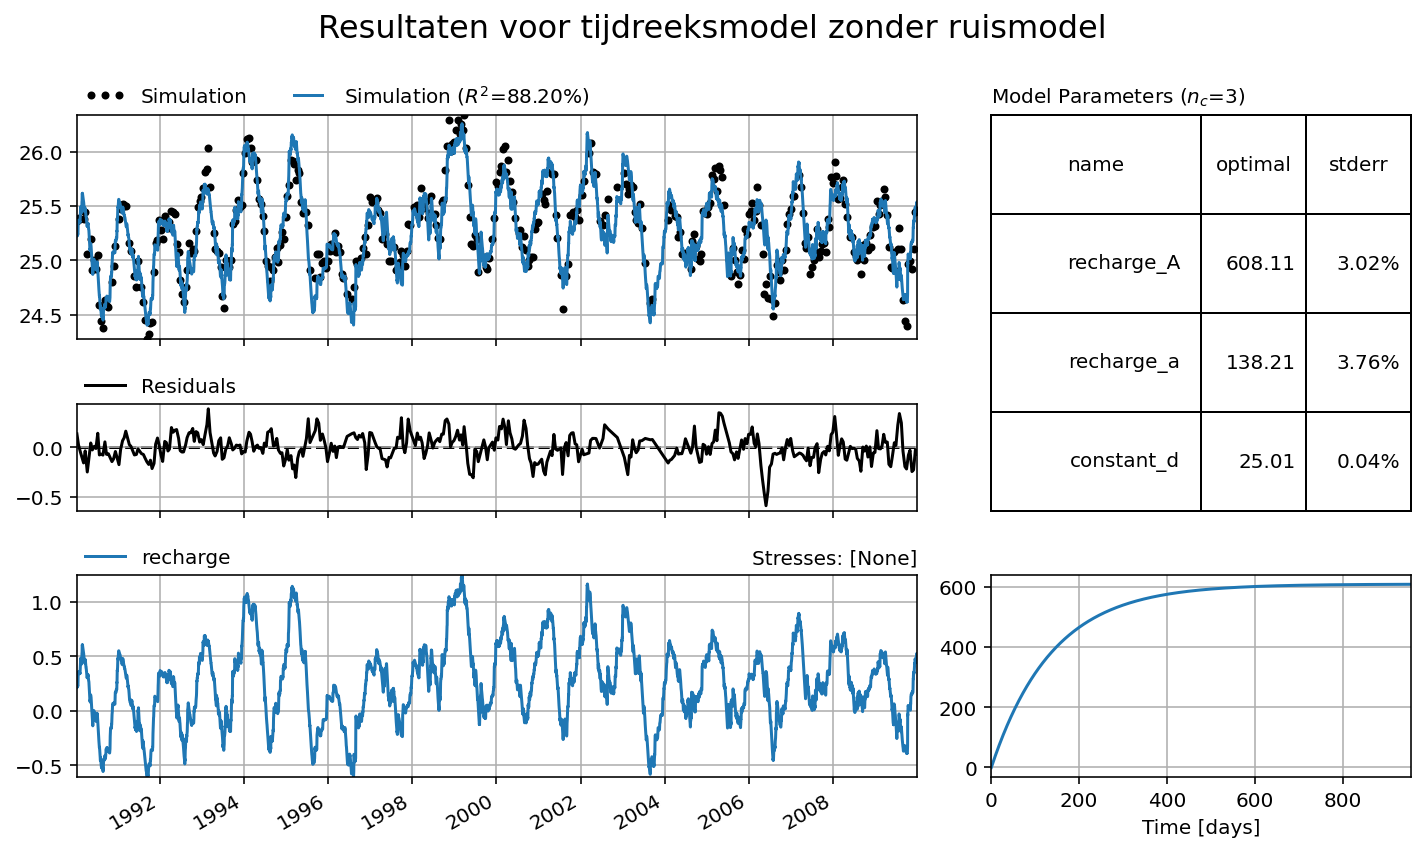

In [16]:
delt = (ho.index[1:] - ho.index[:-1]).values / pd.Timedelta("1d")
np.random.seed(1)
noise = sigma_n * np.random.randn(len(ho))
residuals = np.zeros_like(noise)
residuals[0] = noise[0]
for i in range(1, len(ho)):
    residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
hsynthetic = hsynthetic_no_error + residuals
#
ml = ps.Model(hsynthetic)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False, noise=False)
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle('Resultaten voor tijdreeksmodel zonder ruismodel', fontsize=16)
plt.tight_layout()
a_min = ml.parameters.loc['recharge_a', 'optimal'] - \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
a_max = ml.parameters.loc['recharge_a', 'optimal'] + \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
print(f'geschatte 95% betrouwbaarheidsinterval a: {a_min:.2f} - {a_max:.2f}')

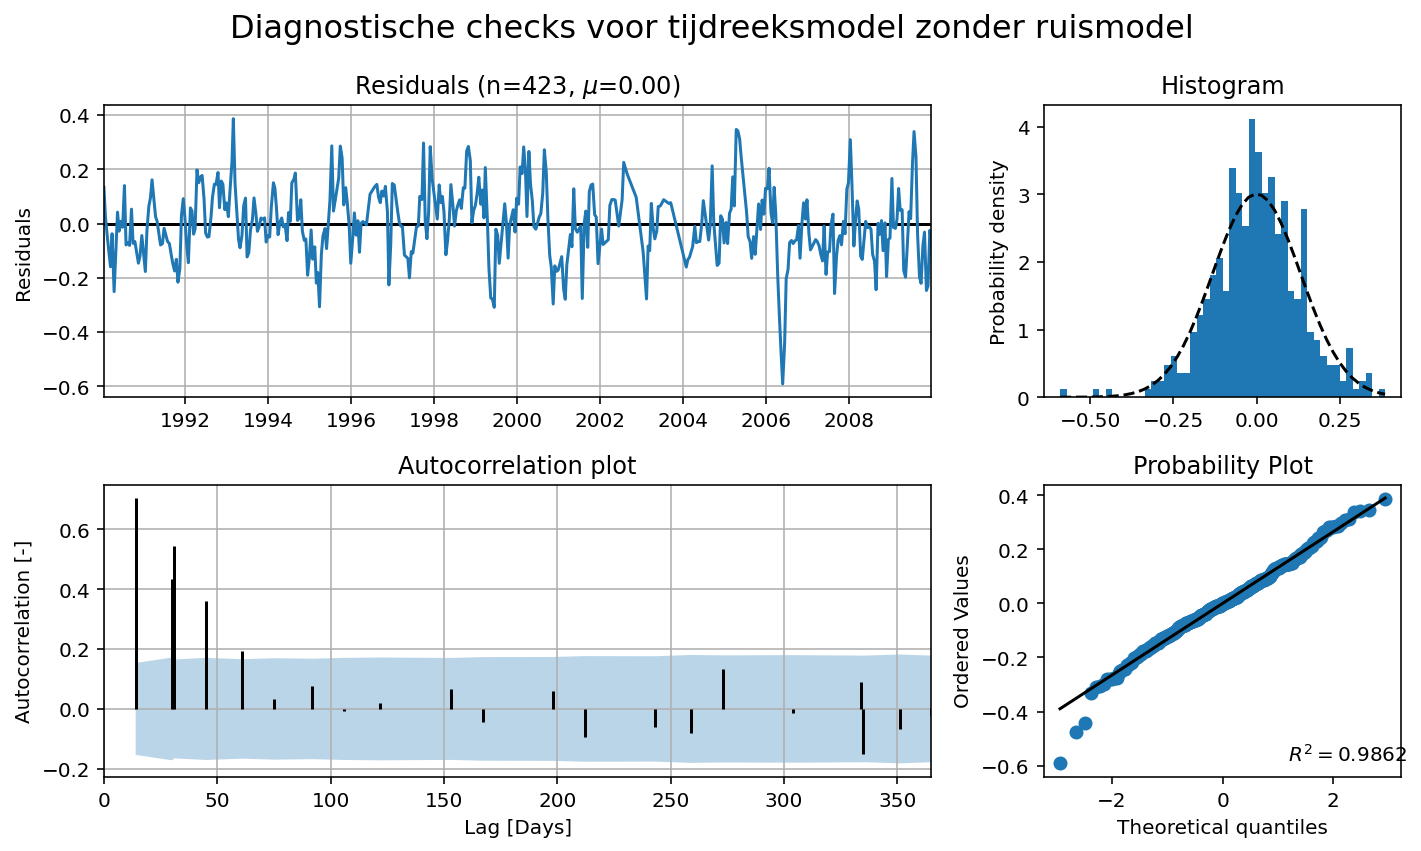

In [17]:
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostische checks voor tijdreeksmodel zonder ruismodel', fontsize=16)
plt.tight_layout()

Als we nu de wederom een tijdreeksmodel maken van de synthetische stijghoogtereeks, maar dit keer wel een ruismodel toevoegen, dan is de fit wederom goed en komen de geschatte parameters wederom goed overeen met de opgegeven parameters, maar nu is de autocorrelatie van de ruis binnen het geaccepteerde niveau. Het ruismodel heeft zijn werk goed gedaan. De fit van het tijdreeksmodel met een ruismodel is altijd lager dan de fit van een tijdreeksmodel zonder ruismodel. Het verschil is hier echter klein.  

geschatte 95% betrouwbaarheidsinterval a: 123.46 - 162.17


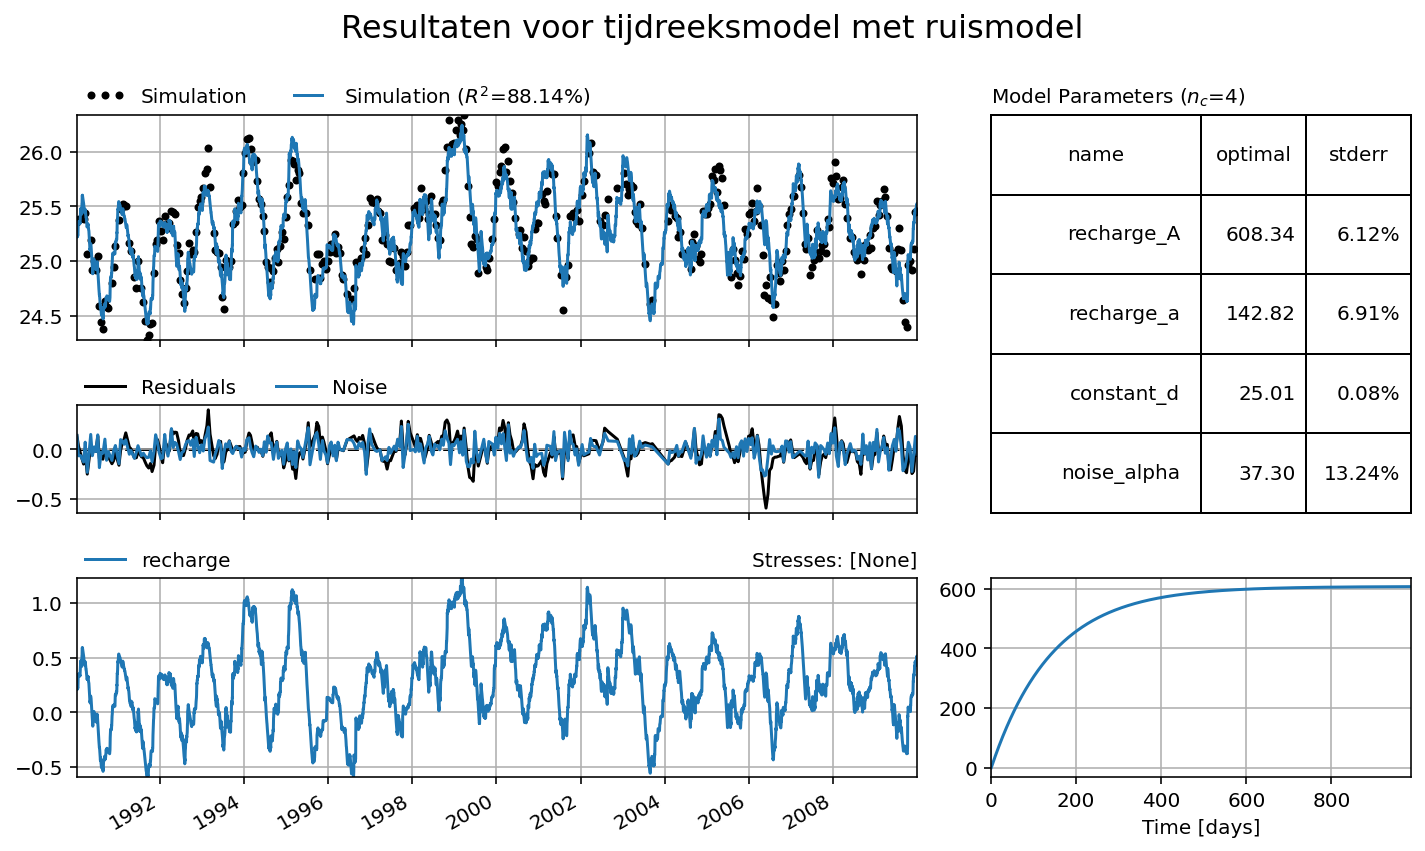

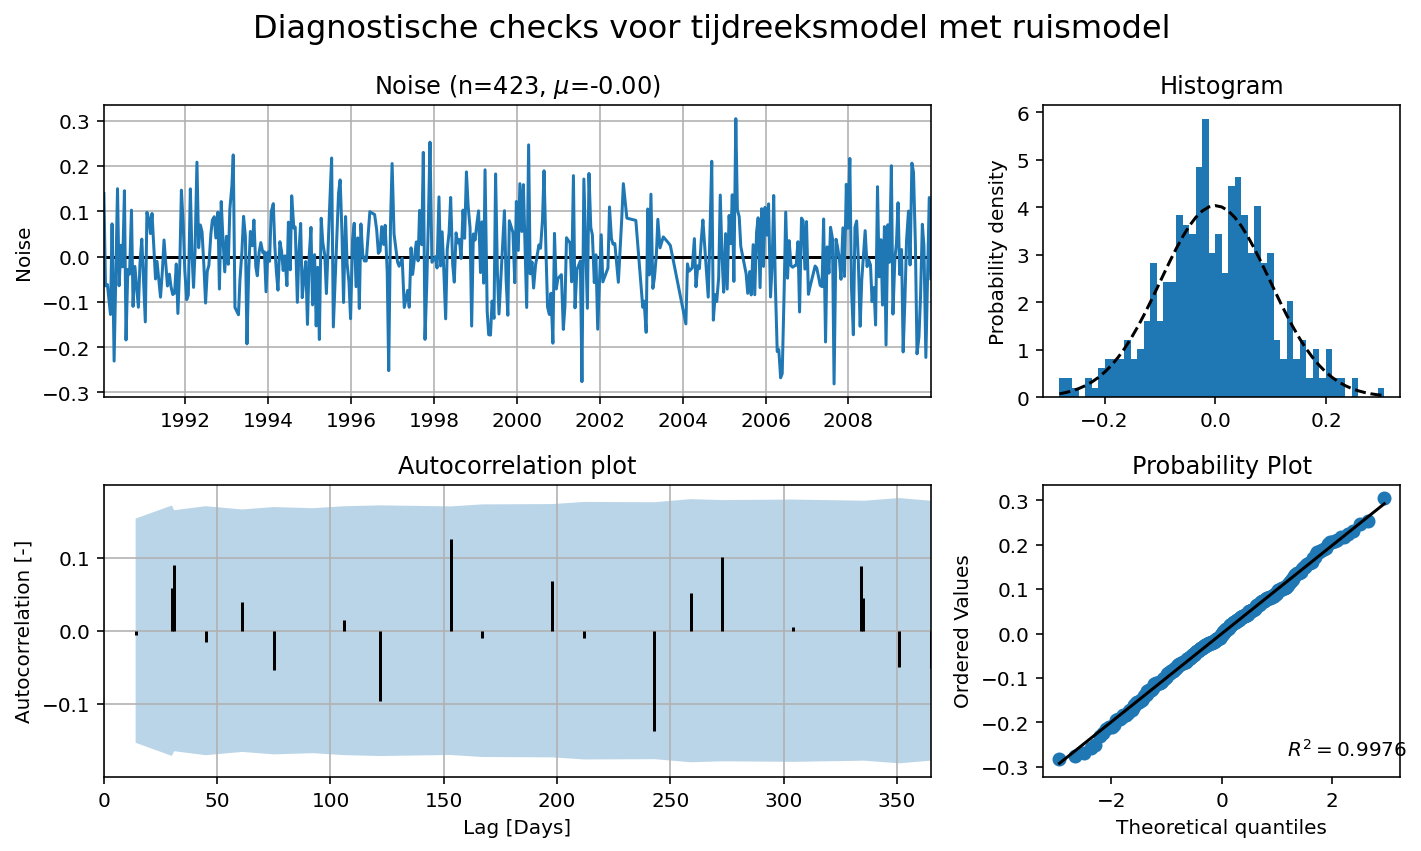

In [18]:
ml = ps.Model(hsynthetic)
rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False, noise=True)
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle('Resultaten voor tijdreeksmodel met ruismodel', fontsize=16)
plt.tight_layout()
#
a_min = ml.parameters.loc['recharge_a', 'optimal'] - \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
a_max = ml.parameters.loc['recharge_a', 'optimal'] + \
    1.96 * ml.parameters.loc['recharge_a', 'stderr']
print(f'geschatte 95% betrouwbaarheidsinterval a: {a_min:.2f} - {a_max:.2f}')
#
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostische checks voor tijdreeksmodel met ruismodel', fontsize=16)
plt.tight_layout()

## Effect van het ruismodel op de schatting van de waarden en betrouwbaarheid van de parameters 
Als het ruismodel niet toegepast wordt, dan valt de echte waarde van $a$ dus niet binnen het geschatte betrouwbaarheidsinterval, terwijl als het ruismodel wel toegepast wordt, valt de echte waarde van $a$ wel binnen het geschatte betrouwbaarheidsinterval. Dit kan natuurlijk toeval zijn (het is immers een 95% betrouwbaarheidsinterval, dus er is een 5% kans dat de echte waarde er buiten valt). Daarom gaan we een experiment doen. In het experiment creëren we 100 keer een synthetische reeks, met steeds andere (gecorreleerde) foutjes. Van alle 100 synthetische reeksen maken we een tijdreeksmodel. Daar de synthetische reeks elke keer andere (gecorreleerde) foutjes heeft, zijn de optimale parameters elke keer een beetje anders. Het experiment is twee keer gedaan. De eerste keer is er 100 keer een tijdreeksmodel gemaakt zonder een ruismodel en vervolgens is er 100 keer een tijdreeksmodel gemaakt met een ruismodel.

In [19]:
def experiment(nexp, sigma_noise=0.1, noisemodel=True):
    Aexp = np.zeros((nexp, 2))
    aexp = np.zeros((nexp, 2))
    dexp = np.zeros((nexp, 2))
    alphaexp = np.zeros((nexp, 2))
    evpexp = np.zeros(nexp)
    print('progress of experiment:')
    for iexp in range(nexp):
        if (iexp + 1) % 20 == 0:
            print(iexp + 1, end='%, ')
        np.random.seed(iexp)
        noise = sigma_noise * np.random.randn(len(ho))
        residuals = np.zeros_like(noise)
        residuals[0] = noise[0]
        for i in range(1, len(ho)):
            residuals[i] = np.exp(-delt[i - 1] / alpha) * \
                residuals[i - 1] + noise[i]
        hsynthetic = hsynthetic_no_error + residuals
        ml = ps.Model(hsynthetic)
        rm = ps.StressModel(recharge, ps.Exponential, name='recharge')
        ml.add_stressmodel(rm)
        ml.solve(report=False, noise=noisemodel)
        Aexp[iexp] = ml.parameters.loc['recharge_A', ['optimal', 'stderr']]
        aexp[iexp] = ml.parameters.loc['recharge_a', ['optimal', 'stderr']]
        dexp[iexp] = ml.parameters.loc['constant_d', ['optimal', 'stderr']]
        if noisemodel:
            alphaexp[iexp] = ml.parameters.loc['noise_alpha',
                                               ['optimal', 'stderr']]
        evpexp[iexp] = ml.stats.evp()
    return Aexp, aexp, dexp, alphaexp, evpexp

In [20]:
result_no_noisemodel = experiment(100, noisemodel=False)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [21]:
print('Results without a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_no_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_no_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_no_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of evp: {np.mean(result_no_noisemodel[4]):.2f}')

Results without a noise model
Mean value of parameter A: 603.36
Mean value of parameter a: 151.43
Mean value of parameter d: 25.00
Mean value of evp: 85.12


In [22]:
result_with_noisemodel = experiment(100, noisemodel=True)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [23]:
print('Results with a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_with_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_with_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_with_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of parameter alpha: '
      f'{np.mean(result_with_noisemodel[3][:, 0]):.2f}')
print(f'Mean value of evp: '
      f'{np.mean(result_with_noisemodel[4]):.2f}')

Results with a noise model
Mean value of parameter A: 600.78
Mean value of parameter a: 150.43
Mean value of parameter d: 25.00
Mean value of parameter alpha: 45.86
Mean value of evp: 85.07


Het blijkt dat zowel het tijdreeksmodel zonder het ruismodel als het tijdreeksmodel met het ruismodel gemiddeld een goede schatting geeft van de parameters. Dus waarom moeten we dan een ruismodel gebruiken? De reden is dat de geschatte onzekerheid van de parameters te klein is als er geen ruismodel gebruikt wordt. De statistische manier waarop de onzekerheid geschat wordt gaat er namelijk van uit dat de overgebleven ruis niet gecorreleerd is. Als de ruis echter toch gecorreleerd is, dan is de geschatte onzekerheid te klein. Dit kan gemakkelijk nagegaan worden met het hierboven uitgevoerde experiment. Tijdens het experiment zijn de parameters 100 keer geschat inclusief een schatting van de standaard fout van de parameters. Onder enkele statistische aannames (inclusief de aannames van normaliteit en ongecorreleerde ruis), is het 95% betrouwbaarheidsinterval tussen min twee keer de standaard fout tot plus twee keer de standaard fout (eigenlijk is het 1.96 i.p.v. 2, maar laten we dat hier maar afronden). Er kan dus eenvoudig nagegaan worden hoe vaak de echte waarden van de parameters (waarmee de synthetische reeks gegenereerd is) binnen het 95% betrouwbaarheidsinterval van de geschatte parameters liggen. Aangezien we het experiment 100 keer gedaan hebben, zou dit ongeveer 95 keer het geval moeten zijn. Zoals te zien is hieronder, geeft het tijdreeksmodel zonder ruismodel slechts zo'n 60-65 keer een betrouwbaarheidsinterval dat de echte waarde bevat. Het tijdreeksmodel met een ruismodel doet het veel beter: meer dan 95 keer liggen de echte parameters van de responsfuncties binnen het 95% betrouwbaarheidsinterval. Samenvattend kan gezegd worden dat zonder ruismodel de parameters gemiddeld wel goed geschat worden, maar dat de betrouwbaarheidsintervallen van de parameters te klein geschat worden.

In [24]:
Aexp, aexp, dexp, alphaexp, evp = result_no_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 66
number of times true a within estimated confidence interval: 72
number of times true d within estimated confidence interval: 53


In [25]:
Aexp, aexp, dexp, alphaexp, evp = result_with_noisemodel
print('results without noise model')
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))
print('number of times true alpha within estimated confidence interval:',
      np.count_nonzero(np.abs(alphaexp[:, 0] - alpha) < 1.96 * alphaexp[:, 1]))

results without noise model
number of times true A within estimated confidence interval: 96
number of times true a within estimated confidence interval: 95
number of times true d within estimated confidence interval: 98
number of times true alpha within estimated confidence interval: 86


## Effect van een fout in de gemeten grondwateraanvulling
In bovenstaand experiment is uitgelegd wat het voordeel van het gebruik van een ruismodel is. Als er geen ruismodel gebruikt wordt, dan worden de parameters goed geschat, maar de betrouwbaarheidsintervallen van de parameters zijn te klein. Als het ruismodel wel meegenomen wordt, dan wordt het betrouwbaarheidsinterval veel beter geschat. In bovenstaand voorbeeld was de fout in de stijghoogte gegenereerd met een model dat precies hetzelfde is als het ruismodel dat in het tijdreeksmodel gebruikt werd. Zoals uitgelegd is de correlatie in de residuën in de werkelijkheid het gevolg van fysische processen, bijvoorbeeld een verschil tussen de gemeten regenval bij het weerstation en de gevallen regenval bij de peilbuis. In de volgende test wordt het bovenstaande experiment herhaald, maar deze keer wordt er geen gecorreleerde fout opgeteld bij de stijghoogte, maar wordt er een grondwateraanvullingsreeks (regen min verdamping) gebruikt die een fout bevat. Er zijn vele manieren waarop er een realistische fout toegevoegd kan worden aan regen of verdampings reeksen. Hier is er voor gekozen om de gemeten grondwateraanvulling te vermenigvuldigen met een factor $(1 + \varepsilon_g)$, waarbij $\varepsilon_g$ normaal verdeeld is met een gemiddelde nul en standaardafwijking $\sigma_g$. Zodoende is de grondwateraanvulling elke dag dus iets meer of iets minder dan gemeten. De gekozen waarde van $\sigma_g$ is 0.2. 

Hieronder wordt een tijdreeksmodel gemaakt, waarbij wederom een AR1 ruismodel meegefit wordt. 
Zoals te zien is, is de fit zeer goed en is er vrijwel geen autocorrelatie in de ruis, maar de ruis is niet erg normaal verdeeld. Dit baart zorgen, want in het bepalen van de betrouwbaarheidsintervallen van de parameters wordt er vanuit gegaan de ruis normaal verdeeld is. 

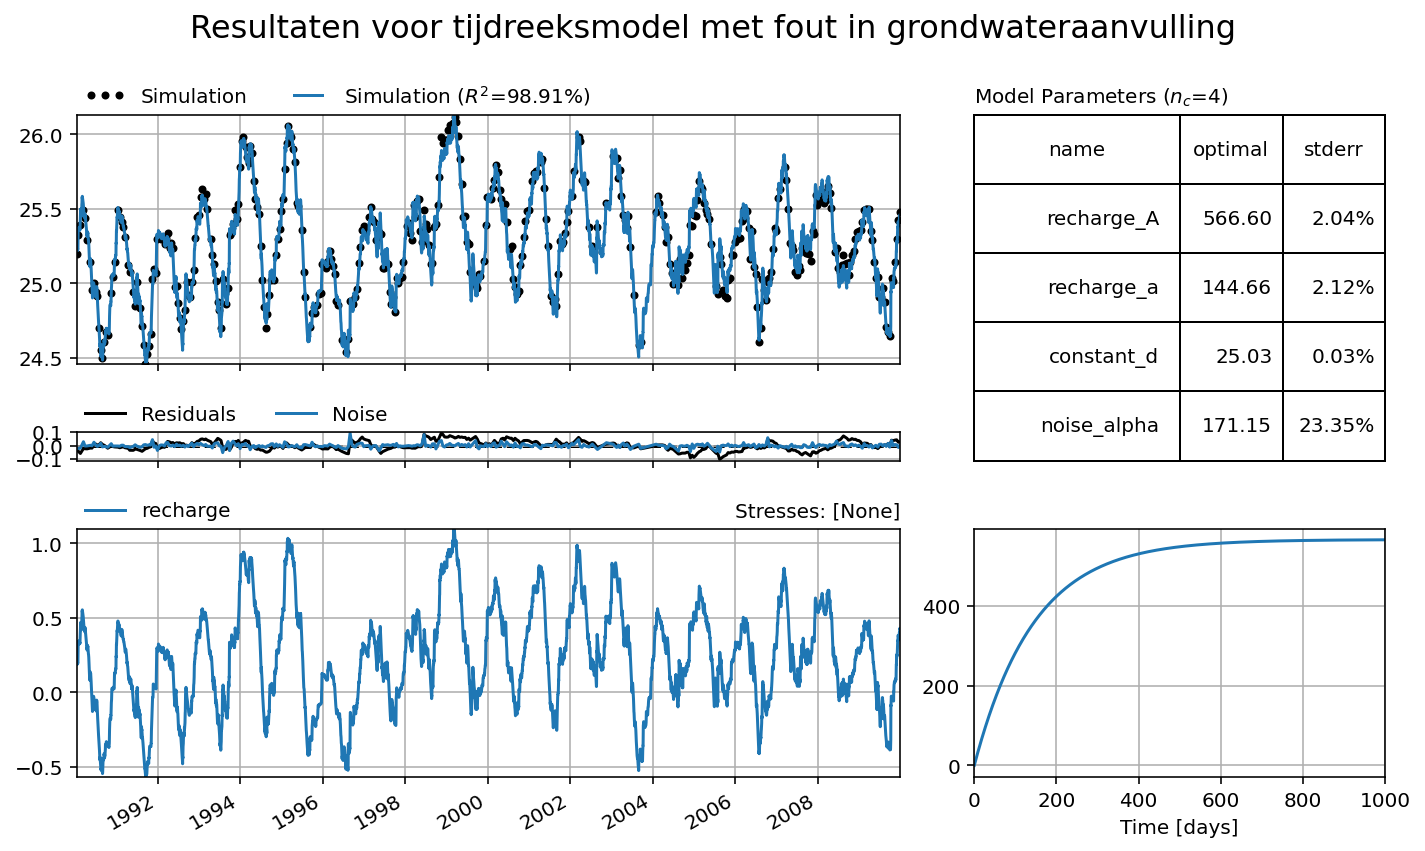

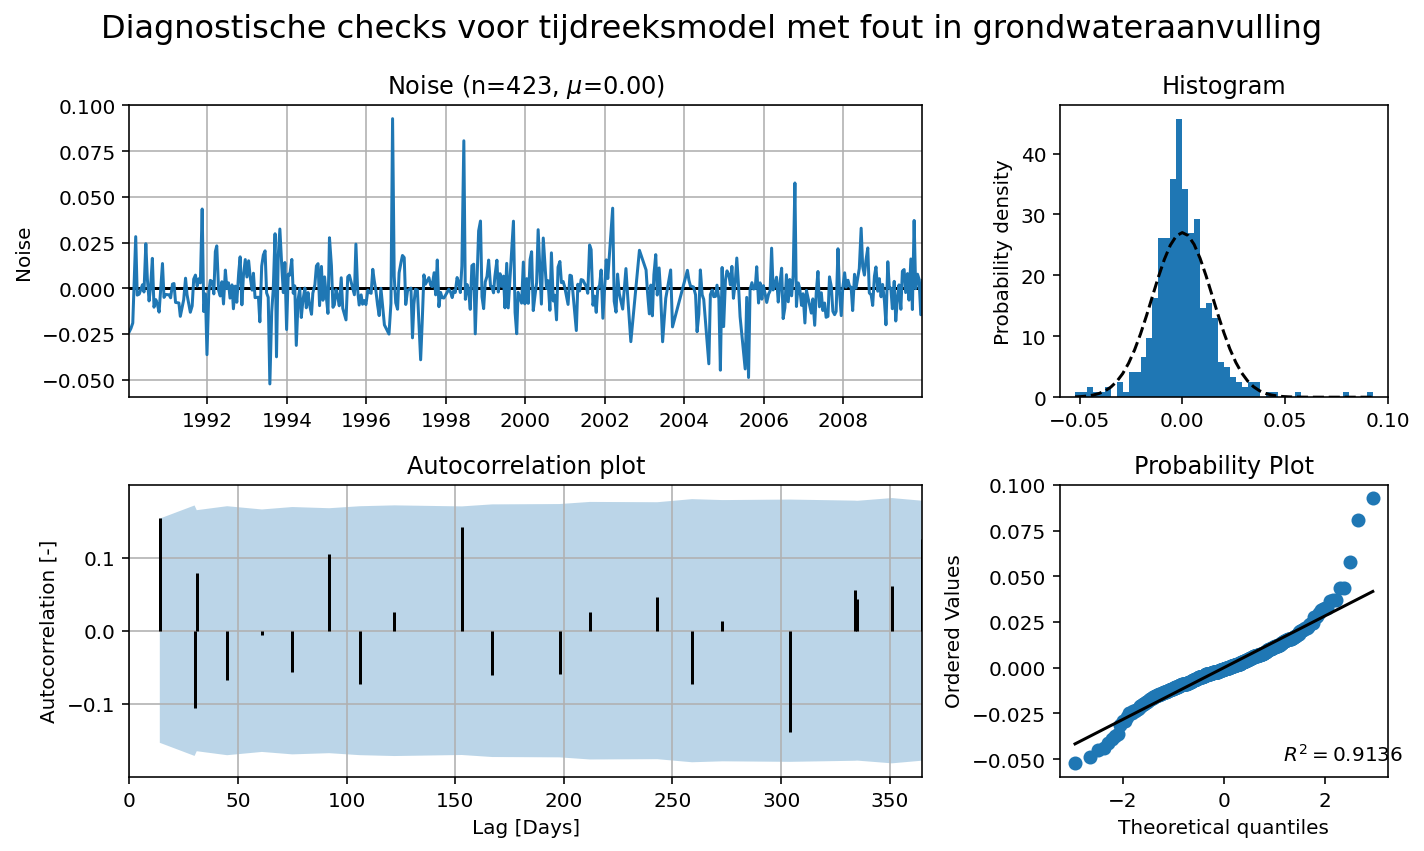

In [26]:
np.random.seed(100)
factor = 1 + 0.2 * np.random.randn(len(recharge))
ml = ps.Model(hsynthetic_no_error)
rm = ps.StressModel(factor * recharge, ps.Exponential, name='recharge')
ml.add_stressmodel(rm)
ml.solve(report=False)
#
ml.plots.results(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Resultaten voor tijdreeksmodel met fout in grondwateraanvulling', fontsize=16)
plt.tight_layout()
ml.plots.diagnostics(figsize=(10, 6))
fig = plt.gcf()
fig.suptitle(
    'Diagnostische checks voor tijdreeksmodel met fout in grondwateraanvulling', fontsize=16)
plt.tight_layout()

We gaan wederom het hierboven beschreven experiment uitvoeren. De tijdreeksmodellen zonder noise model blijken de parameters wederom goed te schatten, maar de betrouwbaarheidsintervallen van de parameters zijn veel te klein: bij slechts 30-40% van de modellen liggen de echte parameters binnen de betrouwbaarheidsintervallen van de geschatte parameters. Ook de tijdreeksmodellen met ruismodel geven goede resultaten voor de geschatte parameters. Bij 80-85% van de modellen liggen de echte parameters binnen de betrouwbaarheidsintervallen van de geschatte parameters. Dat is minder dan de verwachte 95% en komt hoogst waarschijnlijk omdat de ruis niet normaal verdeeld is. Om dit beter te krijgen zou een tijdreeksmodel gebruikt moeten worden gebaseerd op, bijvoorbeeld, een maximum likelihood schatting van de parameters, waarbij opgegeven kan worden wat de verwachte verdeling is van de ruis (zie bijvoorbeel van der Spek en Bakker, 2017). In de meeste huidige versies van software voor tijdreeksanalyse is het echter niet mogelijk om een maximum likelihood functie te definieren. 

In [27]:
def experiment(nexp, sigma_noise=0.1, noisemodel=True):
    Aexp = np.zeros((nexp, 2))
    aexp = np.zeros((nexp, 2))
    dexp = np.zeros((nexp, 2))
    alphaexp = np.zeros((nexp, 2))
    evpexp = np.zeros(nexp)
    print('progress of experiment:')
    for iexp in range(nexp):
        if (iexp + 1) % 20 == 0:
            print(iexp + 1, end='%, ')
        np.random.seed(iexp)
        factor = 1 + 0.2 * np.random.randn(len(recharge))
        ml = ps.Model(hsynthetic_no_error)
        rm = ps.StressModel(factor * recharge, ps.Exponential, name='recharge')
        ml.add_stressmodel(rm)
        ml.solve(report=False, noise=noisemodel)
        Aexp[iexp] = ml.parameters.loc['recharge_A', ['optimal', 'stderr']]
        aexp[iexp] = ml.parameters.loc['recharge_a', ['optimal', 'stderr']]
        dexp[iexp] = ml.parameters.loc['constant_d', ['optimal', 'stderr']]
        if noisemodel:
            alphaexp[iexp] = ml.parameters.loc['noise_alpha',
                                               ['optimal', 'stderr']]
        evpexp[iexp] = ml.stats.evp()
    return Aexp, aexp, dexp, alphaexp, evpexp

In [28]:
result_no_noisemodel = experiment(100, noisemodel=False)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [29]:
result_with_noisemodel = experiment(100, noisemodel=True)

progress of experiment:
20%, 40%, 60%, 80%, 100%, 

In [30]:
print('Results of models with error in recharge, without a noise model')
print('Mean value of parameter A:'
      f' {np.mean(result_no_noisemodel[0][:, 0]):.2f}')
print('Mean value of parameter a: '
      f'{np.mean(result_no_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_no_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of evp: {np.mean(result_no_noisemodel[4]):.2f}')

Results of models with error in recharge, without a noise model
Mean value of parameter A: 591.77
Mean value of parameter a: 149.31
Mean value of parameter d: 25.00
Mean value of evp: 99.16


In [31]:
Aexp, aexp, dexp, alphaexp, evp = result_no_noisemodel
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))

number of times true A within estimated confidence interval: 38
number of times true a within estimated confidence interval: 37
number of times true d within estimated confidence interval: 30


In [32]:
print('Results of models with error in recharge, with a noise model')
print(f'Mean value of parameter A: '
      f'{np.mean(result_with_noisemodel[0][:, 0]):.2f}')
print(f'Mean value of parameter a: '
      f'{np.mean(result_with_noisemodel[1][:, 0]):.2f}')
print(f'Mean value of parameter d: '
      f'{np.mean(result_with_noisemodel[2][:, 0]):.2f}')
print(f'Mean value of parameter alpha: '
      f'{np.mean(result_with_noisemodel[3][:, 0]):.2f}')
print(f'Mean value of evp: '
      f'{np.mean(result_with_noisemodel[4]):.2f}')

Results of models with error in recharge, with a noise model
Mean value of parameter A: 593.64
Mean value of parameter a: 150.54
Mean value of parameter d: 25.00
Mean value of parameter alpha: 142.90
Mean value of evp: 99.15


In [33]:
Aexp, aexp, dexp, alphaexp, evp = result_with_noisemodel
print('number of times true A within estimated confidence interval:',
      np.count_nonzero(np.abs(Aexp[:, 0] - A) < 1.96 * Aexp[:, 1]))
print('number of times true a within estimated confidence interval:',
      np.count_nonzero(np.abs(aexp[:, 0] - a) < 1.96 * aexp[:, 1]))
print('number of times true d within estimated confidence interval:',
      np.count_nonzero(np.abs(dexp[:, 0] - d) < 1.96 * dexp[:, 1]))
#print('number of times true alpha within estimated confidence interval:', np.count_nonzero(np.abs(alphaexp[:, 0] - alpha) < 1.96 * alphaexp[:, 1]))

number of times true A within estimated confidence interval: 80
number of times true a within estimated confidence interval: 84
number of times true d within estimated confidence interval: 86


## Effect van de meetfrequentie op de werking van het AR1 ruismodel

Het is vaak moeilijk, met de huidige algoritmes, om de residuën te transformeren naar ruis met verwaarloosbare autocorrelatie voor tijdreeksmodellen van stijghoogtes die dagelijks gemeten zijn. Een praktische oplossing kan dan zijn om de frequentie van de metingen te verlagen, bijvoorbeeld om alleen een meting om de week of om de twee weken te gebruiken. 

Beschouw bijvoorbeeld peilbuis B16G0187_2 in het plaatsje Witte Paarden in Steenwijkerland. De stijghoogte is dagelijks gemeten tussen 2005 en 2018. Een tijdreeksmodel met regen en potentiële verdamping geeft een goede fit (zie hieronder), maar er is nog een duidelijke autocorrelatie in de residuën. 

In [34]:
ho = pd.read_csv('data/B16G0187_2.csv',
                 parse_dates=[0], index_col=0, squeeze=True)
rain = pd.read_csv('data/Frederiksoord.csv',
                   parse_dates=[0], index_col=0, squeeze=True)
evap = pd.read_csv('data/Marknesse.csv',
                   parse_dates=[0], index_col=0, squeeze=True)

Fit report B16G0187_2              Fit Statistics
nfev    30                     EVP           86.78
nobs    4744                   R2             0.87
noise   1                      RMSE           0.07
tmin    2005-01-01 00:00:00    AIC         9681.41
tmax    2018-04-04 00:00:00    BIC         9720.20
freq    D                      Obj            3.84
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal  stderr     initial  vary
recharge_A   324.803629  ±3.99%  202.753032  True
recharge_n     1.161756  ±2.24%    1.000000  True
recharge_a   128.228562  ±6.00%   10.000000  True
recharge_f    -0.986536  ±3.40%   -1.000000  True
constant_d    -0.666379  ±3.52%   -0.419248  True
noise_alpha    4.275741  ±4.82%    1.000000  True


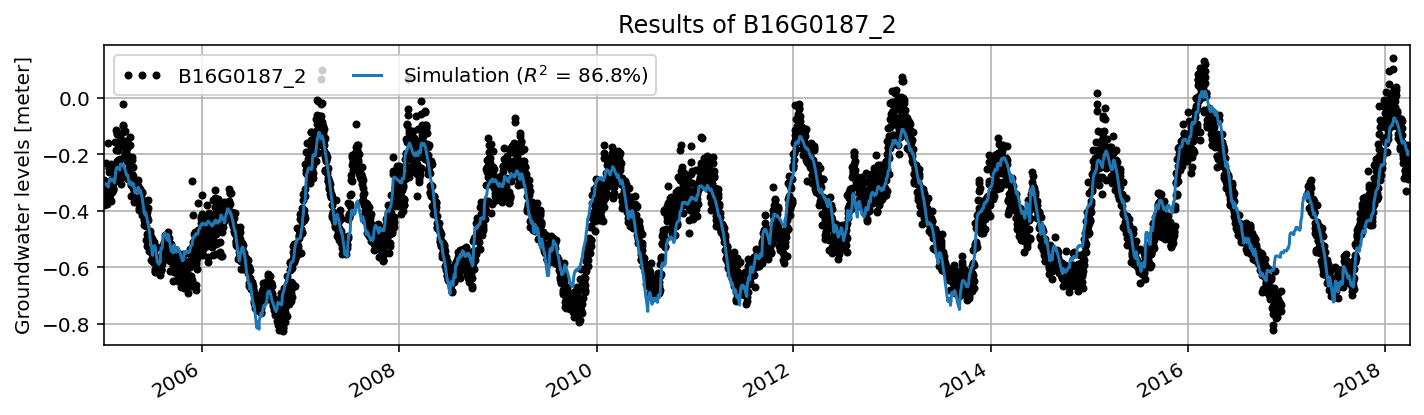

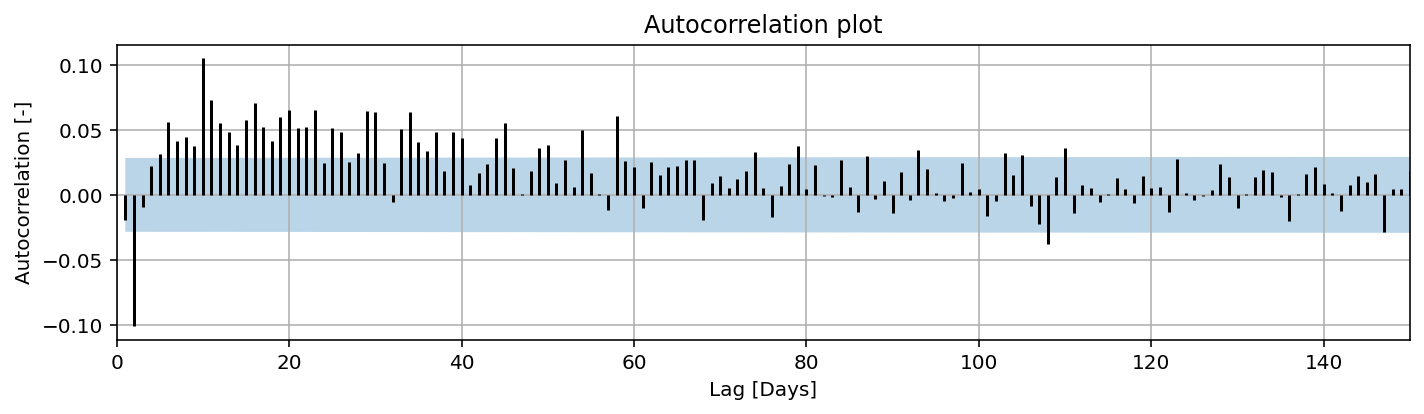

In [35]:
ml = ps.Model(ho)
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve()
ax = ml.plot(figsize=(10, 3))
ax.grid()
ax = ps.stats.plot_acf(ml.noise(), figsize=(10, 3), alpha=0.05)
ax.set_xlim(0, 150)
plt.tight_layout()

Vervolgens is het tijdreeksmodel nogmaals gefit, maar nu alleen op 14-daagse metingen. Het aantal observaties waarop gefit wordt is daardoor teruggebracht van meer dan 4500 naar minder dan 400. De fit is ongeveer even goed en alle modelparameters zijn vergelijkbaar, behalve de parameter $\alpha$ van het ruismodel die nu 5 keer zo groot is. Maar, en daar ging het om, de autocorrelatie in de ruis is nu verwaarloosbaar, zodat de standaardfouten (`stderr`) van de parameters gebruikt mogen worden om schattingen te doen van de betrouwbaarheidsintervallen van de parameters (als ook aan de andere statistiche voorwaarden voldaan is). Merk ook op dat voor deze buis, de standaardfout van de parameters in het model dat gefit is op 14-daagse metingen voor de meeste parameters ongeveer twee keer zo groot is als voor de parameters in het model dat gefit is op dagelijkse metingen. 

Fit report B16G0187_2               Fit Statistics
nfev    14                     EVP           86.99
nobs    339                    R2             0.87
noise   1                      RMSE           0.07
tmin    2005-01-01 00:00:00    AIC           25.45
tmax    2018-03-24 00:00:00    BIC           48.41
freq    D                      Obj            0.52
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr     initial  vary
recharge_A   311.113217   ±8.37%  202.753032  True
recharge_n     1.282130   ±4.82%    1.000000  True
recharge_a   104.497496  ±11.70%   10.000000  True
recharge_f    -0.947278   ±7.20%   -1.000000  True
constant_d    -0.678718   ±7.12%   -0.420647  True
noise_alpha   22.393984  ±13.98%   14.000000  True


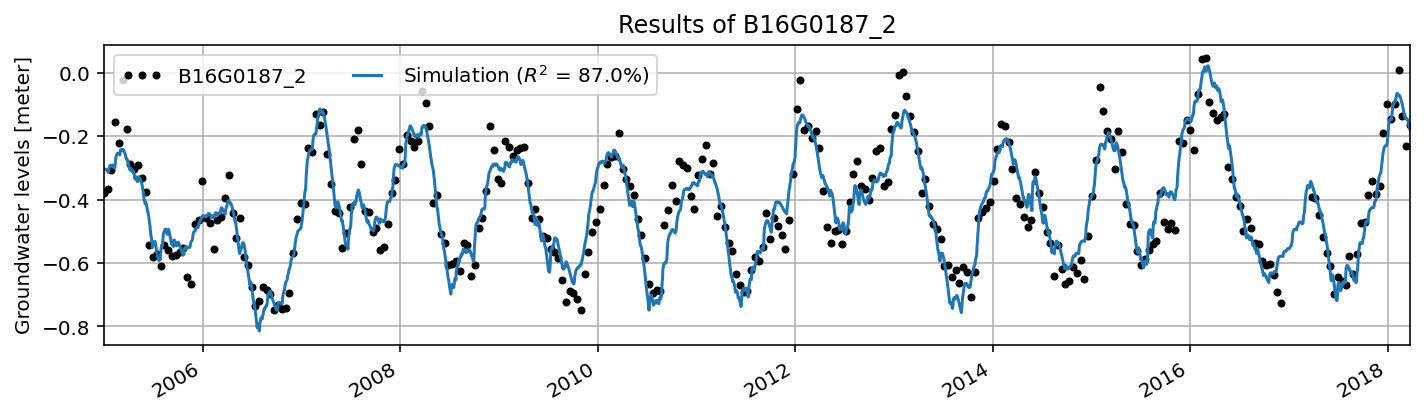

In [36]:
ml = ps.Model(ho.iloc[::14])
rm = ps.RechargeModel(rain, evap, ps.Gamma, name='recharge')
ml.add_stressmodel(rm)
ml.solve()
ax = ml.plot(figsize=(10, 3))
ax.grid()

## Referenties

- J.E. van der Spek, J.E. and M. Bakker, 2017. The influence of the length of the calibration period and observation frequency on predictive uncertainty in time series modeling of groundwater dynamics. Water Resources Research, 53(3), pp.2294-2311.